In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

In [ ]:
from google.colab import files
import zipfile

uploaded = files.upload()       # pick 32.zip

Saving 32.zip to 32.zip


In [ ]:
with zipfile.ZipFile("32.zip", 'r') as zf:
    zf.extractall("/content/joypixels-32")

Path = "/content/joypixels-32/32"

In [ ]:
import os
import zipfile
from google.colab import files
print("Total images:", len(os.listdir(Path)))

Total images: 3671


In [ ]:
 !pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 29.9 MB/s eta 0:00:00


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance


In [ ]:
batch_size = 64
z_dim = 100
iterations = 20000
save_interval = 200
lr = 0.0002
latent_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Your existing generator
generator = nn.Sequential(
    nn.Linear(100, 4*4*128),
    nn.Unflatten(1, (128, 4, 4)),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
).to(device)


In [ ]:
# Your existing discriminator
discriminator = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),

    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),

    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
).to(device)


In [ ]:

# Helper functions
def denorm(img_tensors):
    return (img_tensors + 1) / 2  # Convert from [-1,1] to [0,1]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [ ]:

# Dataset setup
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Update this path to your dataset
dataset = datasets.ImageFolder(root="/content/joypixels-32", transform=transform)
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)


In [ ]:
# Loss & Optimizers
criterion = nn.BCELoss()  # Changed from MSE to BCE for better GAN training
opt_d = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))
opt_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed latent for visualization
fixed_latent = torch.randn(64, latent_size, device=device)


In [ ]:
# Training Functions
def train_discriminator(real_images):
    opt_d.zero_grad()

    # Real images
    real_targets = torch.ones(real_images.size(0), device=device)
    real_preds = discriminator(real_images).squeeze()
    real_loss = criterion(real_preds, real_targets)

    # Fake images
    z = torch.randn(real_images.size(0), latent_size, device=device)
    fake_images = generator(z)
    fake_targets = torch.zeros(real_images.size(0), device=device)
    fake_preds = discriminator(fake_images.detach()).squeeze()
    fake_loss = criterion(fake_preds, fake_targets)

    # Combine losses
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    opt_d.step()

    return d_loss.item()

def train_generator(batch_size):
    opt_g.zero_grad()
    z = torch.randn(batch_size, latent_size, device=device)
    fake_images = generator(z)
    fake_targets = torch.ones(batch_size, device=device)
    preds = discriminator(fake_images).squeeze()
    g_loss = criterion(preds, fake_targets)
    g_loss.backward()
    opt_g.step()
    return g_loss.item()


In [ ]:
# Create directories
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

# Training Loop
print("Starting training...")
d_losses, g_losses = [], []
iter_count = 0

pbar = tqdm(range(iterations))
while iter_count < iterations:
    for real_images, _ in train_dl:
        # Train discriminator and generator
        d_loss = train_discriminator(real_images)
        g_loss = train_generator(real_images.size(0))

        d_losses.append(d_loss)
        g_losses.append(g_loss)

        # Save samples every 200 iterations
        if iter_count % save_interval == 0:
            with torch.no_grad():
                fake_images = generator(fixed_latent).cpu()
                save_image(denorm(fake_images), os.path.join(sample_dir, f"sample-{iter_count:05d}.png"), nrow=8)
            print(f"Iter [{iter_count:05d}/{iterations:05d}]  D_loss: {d_loss:.4f}  G_loss: {g_loss:.4f}")

        iter_count += 1
        pbar.update(1)
        if iter_count >= iterations:
            break

pbar.close()
print("Training completed!")


Starting training...


  0%|          | 7/20000 [00:01<57:21,  5.81it/s]  

Iter [00000/20000]  D_loss: 0.6812  G_loss: 0.7520


  1%|          | 203/20000 [00:08<17:00, 19.40it/s]

Iter [00200/20000]  D_loss: 0.4873  G_loss: 1.2583


  1%|▏         | 274/20000 [00:10<09:49, 33.46it/s]

KeyboardInterrupt: 

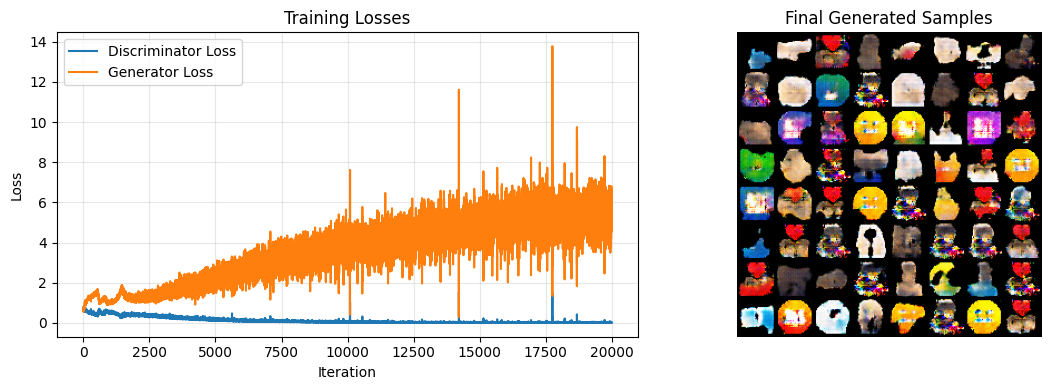

In [ ]:
# Save final models
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')

# Plot losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show final generated samples
with torch.no_grad():
    final_samples = generator(fixed_latent)
    final_samples = denorm(final_samples)
    plt.imshow(make_grid(final_samples, nrow=8).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Final Generated Samples')

plt.tight_layout()
plt.show()


In [ ]:

from torchmetrics.image.fid import FrechetInceptionDistance

def generate_fake_images(generator, num_images, batch_size, device, latent_size):
    """Generate fake images using the trained generator"""
    generator.eval()
    fake_images = []

    with torch.no_grad():
        for i in tqdm(range(0, num_images, batch_size), desc="Generating fake images"):
            current_batch_size = min(batch_size, num_images - i)
            z = torch.randn(current_batch_size, latent_size, device=device)
            fake_batch = generator(z)
            fake_images.append(fake_batch.cpu())

    return torch.cat(fake_images, dim=0)

def convert_images_for_fid(images):
    """Convert images from [-1,1] to [0,255] uint8 format for FID calculation"""
    # Convert from [-1,1] to [0,1]
    images = (images + 1) / 2
    # Convert to [0,255] and uint8
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    return images

# FID Evaluation
print("\n" + "="*50)
print("CALCULATING FID SCORE using torchmetrics")
print("="*50)

# Initialize FID metric
fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

print("Loading real images for FID evaluation...")
# Create dataset for real images
real_dataset = datasets.ImageFolder(root="/content/joypixels-32", transform=transform)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=64, shuffle=True)
real_dataloader = DeviceDataLoader(real_dataloader, device)

# Process real images in batches
real_count = 0
max_real_images = 3000

print("Processing real images...")
for real_batch, _ in tqdm(real_dataloader, desc="Processing real images"):
    if real_count >= max_real_images:
        break

    # Convert to proper format for FID
    real_images_fid = convert_images_for_fid(real_batch)

    # Update FID metric with real images
    fid_metric.update(real_images_fid, real=True)
    real_count += len(real_batch)

print(f"Processed {real_count} real images")

print("Generating and processing fake images...")
# Generate fake images in batches
fake_count = 0
max_fake_images = 3000

fake_images_for_saving = []  # Store some samples for visualization

while fake_count < max_fake_images:
    current_batch_size = min(batch_size, max_fake_images - fake_count)

    # Generate fake images
    with torch.no_grad():
        z = torch.randn(current_batch_size, latent_size, device=device)
        fake_batch = generator(z)

    # Convert to proper format for FID
    fake_images_fid = convert_images_for_fid(fake_batch)

    # Update FID metric with fake images
    fid_metric.update(fake_images_fid, real=False)

    # Save some samples for visualization
    if fake_count < 64:
        fake_images_for_saving.append(fake_batch.cpu())

    fake_count += len(fake_batch)

print(f"Generated {fake_count} fake images")

print("Calculating FID score...")
fid_score = fid_metric.compute()

print(f"\nFID Score: {fid_score:.4f}")
print(f"Lower FID scores indicate better image quality")
print(f"Typical FID ranges:")
print(f"  - Excellent: < 10")
print(f"  - Good: 10-30")
print(f"  - Fair: 30-50")
print(f"  - Poor: > 50")

# Save some generated samples for visual inspection
if fake_images_for_saving:
    print("\nSaving generated samples...")
    sample_images = torch.cat(fake_images_for_saving[:8], dim=0)  # Take first 8 batches
    save_image(denorm(sample_images[:64]), "fid_evaluation_samples.png", nrow=8)

print(f"\nFID Evaluation completed!")


CALCULATING FID SCORE using torchmetrics


ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

Using device: cuda
Starting improved training...



  1%|▏         | 275/20000 [00:16<19:43, 16.67it/s]

  0%|          | 4/20000 [00:00<27:26, 12.15it/s]  

Iter [00000/20000]  D_loss: 0.7094  G_loss: 1.3809  Real_score: 0.528  Fake_score: 0.518



  1%|          | 206/20000 [00:07<10:08, 32.51it/s]

Iter [00200/20000]  D_loss: 0.4811  G_loss: 2.2057  Real_score: 0.718  Fake_score: 0.287



  2%|▏         | 401/20000 [00:14<11:25, 28.59it/s]

Iter [00400/20000]  D_loss: 0.6032  G_loss: 1.0003  Real_score: 0.562  Fake_score: 0.325



  3%|▎         | 606/20000 [00:21<10:15, 31.50it/s]

Iter [00600/20000]  D_loss: 0.4910  G_loss: 1.7606  Real_score: 0.707  Fake_score: 0.291



  4%|▍         | 808/20000 [00:28<10:19, 30.97it/s]

Iter [00800/20000]  D_loss: 0.5453  G_loss: 1.9674  Real_score: 0.705  Fake_score: 0.394



  5%|▌         | 1008/20000 [00:36<10:22, 30.50it/s]

Iter [01000/20000]  D_loss: 0.4973  G_loss: 1.6065  Real_score: 0.615  Fake_score: 0.203



  6%|▌         | 1204/20000 [00:43<16:10, 19.37it/s]

Iter [01200/20000]  D_loss: 0.5005  G_loss: 1.3811  Real_score: 0.644  Fake_score: 0.203



  7%|▋         | 1405/20000 [00:50<10:28, 29.59it/s]

Iter [01400/20000]  D_loss: 0.4937  G_loss: 1.6219  Real_score: 0.679  Fake_score: 0.261



  8%|▊         | 1606/20000 [00:57<09:58, 30.74it/s]

Iter [01600/20000]  D_loss: 0.4682  G_loss: 1.6857  Real_score: 0.852  Fake_score: 0.367



  9%|▉         | 1807/20000 [01:04<10:21, 29.26it/s]

Iter [01800/20000]  D_loss: 0.4671  G_loss: 1.8903  Real_score: 0.766  Fake_score: 0.290



 10%|█         | 2007/20000 [01:11<09:43, 30.85it/s]

Iter [02000/20000]  D_loss: 0.4375  G_loss: 1.7587  Real_score: 0.737  Fake_score: 0.205



 11%|█         | 2203/20000 [01:18<09:28, 31.30it/s]

Iter [02200/20000]  D_loss: 0.4098  G_loss: 1.4650  Real_score: 0.805  Fake_score: 0.193



 12%|█▏        | 2408/20000 [01:26<08:55, 32.84it/s]

Iter [02400/20000]  D_loss: 0.4308  G_loss: 1.6029  Real_score: 0.707  Fake_score: 0.133



 13%|█▎        | 2608/20000 [01:32<09:02, 32.05it/s]

Iter [02600/20000]  D_loss: 0.4866  G_loss: 1.6376  Real_score: 0.733  Fake_score: 0.276



 14%|█▍        | 2805/20000 [01:40<09:13, 31.09it/s]

Iter [02800/20000]  D_loss: 0.4282  G_loss: 1.8171  Real_score: 0.790  Fake_score: 0.221



 15%|█▌        | 3005/20000 [01:47<13:33, 20.88it/s]

Iter [03000/20000]  D_loss: 0.4764  G_loss: 1.7463  Real_score: 0.741  Fake_score: 0.271



 16%|█▌        | 3207/20000 [01:54<09:13, 30.35it/s]

Iter [03200/20000]  D_loss: 0.4380  G_loss: 1.5219  Real_score: 0.771  Fake_score: 0.230



 17%|█▋        | 3407/20000 [02:02<09:10, 30.15it/s]

Iter [03400/20000]  D_loss: 0.4755  G_loss: 1.8273  Real_score: 0.843  Fake_score: 0.347



 18%|█▊        | 3607/20000 [02:09<09:26, 28.94it/s]

Iter [03600/20000]  D_loss: 0.4576  G_loss: 1.9573  Real_score: 0.757  Fake_score: 0.285



 19%|█▉        | 3808/20000 [02:17<08:41, 31.04it/s]

Iter [03800/20000]  D_loss: 0.4388  G_loss: 2.5564  Real_score: 0.797  Fake_score: 0.272



 20%|█▉        | 3999/20000 [02:23<08:25, 31.64it/s]

Iter [04000/20000]  D_loss: 0.4407  G_loss: 1.6579  Real_score: 0.729  Fake_score: 0.218



 21%|██        | 4206/20000 [02:31<08:26, 31.15it/s]

Iter [04200/20000]  D_loss: 0.4273  G_loss: 2.1208  Real_score: 0.861  Fake_score: 0.290



 22%|██▏       | 4404/20000 [02:38<13:49, 18.81it/s]

Iter [04400/20000]  D_loss: 0.4249  G_loss: 1.7327  Real_score: 0.708  Fake_score: 0.094



 23%|██▎       | 4608/20000 [02:46<08:44, 29.36it/s]

Iter [04600/20000]  D_loss: 0.4136  G_loss: 1.5078  Real_score: 0.772  Fake_score: 0.185



 24%|██▍       | 4806/20000 [02:53<08:15, 30.65it/s]

Iter [04800/20000]  D_loss: 0.5092  G_loss: 2.7714  Real_score: 0.894  Fake_score: 0.414



 25%|██▌       | 5005/20000 [03:00<08:27, 29.53it/s]

Iter [05000/20000]  D_loss: 0.4132  G_loss: 2.5021  Real_score: 0.822  Fake_score: 0.216



 26%|██▌       | 5206/20000 [03:08<08:05, 30.47it/s]

Iter [05200/20000]  D_loss: 0.3944  G_loss: 2.2625  Real_score: 0.839  Fake_score: 0.211



 27%|██▋       | 5406/20000 [03:14<08:53, 27.36it/s]

Iter [05400/20000]  D_loss: 0.4146  G_loss: 1.2883  Real_score: 0.813  Fake_score: 0.207



 28%|██▊       | 5607/20000 [03:22<08:06, 29.56it/s]

Iter [05600/20000]  D_loss: 0.4439  G_loss: 1.9152  Real_score: 0.869  Fake_score: 0.324



 29%|██▉       | 5805/20000 [03:29<13:28, 17.56it/s]

Iter [05800/20000]  D_loss: 0.4212  G_loss: 1.8644  Real_score: 0.737  Fake_score: 0.159



 30%|███       | 6005/20000 [03:36<07:57, 29.29it/s]

Iter [06000/20000]  D_loss: 0.4171  G_loss: 2.1797  Real_score: 0.736  Fake_score: 0.171



 31%|███       | 6202/20000 [03:44<10:58, 20.96it/s]

Iter [06200/20000]  D_loss: 0.5028  G_loss: 1.4825  Real_score: 0.595  Fake_score: 0.101



 32%|███▏      | 6406/20000 [03:51<07:43, 29.31it/s]

Iter [06400/20000]  D_loss: 0.4183  G_loss: 2.0311  Real_score: 0.839  Fake_score: 0.269



 33%|███▎      | 6607/20000 [03:59<07:31, 29.65it/s]

Iter [06600/20000]  D_loss: 0.4313  G_loss: 2.1845  Real_score: 0.731  Fake_score: 0.161



 34%|███▍      | 6806/20000 [04:06<07:18, 30.08it/s]

Iter [06800/20000]  D_loss: 0.3997  G_loss: 1.5362  Real_score: 0.812  Fake_score: 0.178



 35%|███▌      | 7006/20000 [04:13<07:06, 30.49it/s]

Iter [07000/20000]  D_loss: 0.4270  G_loss: 2.3992  Real_score: 0.809  Fake_score: 0.244



 36%|███▌      | 7205/20000 [04:21<10:41, 19.96it/s]

Iter [07200/20000]  D_loss: 0.4022  G_loss: 1.7149  Real_score: 0.766  Fake_score: 0.148



 37%|███▋      | 7405/20000 [04:28<07:07, 29.44it/s]

Iter [07400/20000]  D_loss: 0.4403  G_loss: 1.4337  Real_score: 0.729  Fake_score: 0.195



 38%|███▊      | 7608/20000 [04:36<07:39, 26.99it/s]

Iter [07600/20000]  D_loss: 0.4783  G_loss: 1.5935  Real_score: 0.692  Fake_score: 0.242



 39%|███▉      | 7807/20000 [04:43<07:08, 28.45it/s]

Iter [07800/20000]  D_loss: 0.4791  G_loss: 1.6208  Real_score: 0.637  Fake_score: 0.157



 40%|████      | 8000/20000 [04:51<06:39, 30.02it/s]

Iter [08000/20000]  D_loss: 0.4217  G_loss: 1.9721  Real_score: 0.912  Fake_score: 0.264



 41%|████      | 8207/20000 [04:58<06:27, 30.42it/s]

Iter [08200/20000]  D_loss: 0.3986  G_loss: 1.7768  Real_score: 0.796  Fake_score: 0.170



 42%|████▏     | 8408/20000 [05:06<06:12, 31.14it/s]

Iter [08400/20000]  D_loss: 0.3884  G_loss: 2.6006  Real_score: 0.771  Fake_score: 0.115



 43%|████▎     | 8606/20000 [05:13<09:17, 20.45it/s]

Iter [08600/20000]  D_loss: 0.4114  G_loss: 1.8178  Real_score: 0.793  Fake_score: 0.194



 44%|████▍     | 8807/20000 [05:20<06:25, 29.07it/s]

Iter [08800/20000]  D_loss: 0.4815  G_loss: 1.4351  Real_score: 0.626  Fake_score: 0.165



 45%|████▌     | 9005/20000 [05:28<06:32, 27.98it/s]

Iter [09000/20000]  D_loss: 0.4114  G_loss: 3.1646  Real_score: 0.874  Fake_score: 0.280



 46%|████▌     | 9206/20000 [05:35<06:30, 27.67it/s]

Iter [09200/20000]  D_loss: 0.4508  G_loss: 2.0422  Real_score: 0.677  Fake_score: 0.112



 47%|████▋     | 9405/20000 [05:43<06:37, 26.67it/s]

Iter [09400/20000]  D_loss: 0.4237  G_loss: 2.1040  Real_score: 0.722  Fake_score: 0.148



 48%|████▊     | 9604/20000 [05:51<08:45, 19.80it/s]

Iter [09600/20000]  D_loss: 0.3884  G_loss: 2.2683  Real_score: 0.846  Fake_score: 0.178



 49%|████▉     | 9799/20000 [05:59<05:36, 30.29it/s]

Iter [09800/20000]  D_loss: 0.4025  G_loss: 2.2712  Real_score: 0.859  Fake_score: 0.236



 50%|█████     | 10007/20000 [06:07<05:56, 28.01it/s]

Iter [10000/20000]  D_loss: 0.3795  G_loss: 1.8215  Real_score: 0.806  Fake_score: 0.140



 51%|█████     | 10207/20000 [06:15<05:32, 29.47it/s]

Iter [10200/20000]  D_loss: 0.4362  G_loss: 2.4297  Real_score: 0.854  Fake_score: 0.317



 52%|█████▏    | 10404/20000 [06:24<05:50, 27.37it/s]

Iter [10400/20000]  D_loss: 0.4670  G_loss: 1.4182  Real_score: 0.768  Fake_score: 0.282



 53%|█████▎    | 10604/20000 [06:32<08:29, 18.45it/s]

Iter [10600/20000]  D_loss: 0.4605  G_loss: 2.1167  Real_score: 0.927  Fake_score: 0.335



 54%|█████▍    | 10805/20000 [06:39<05:29, 27.91it/s]

Iter [10800/20000]  D_loss: 0.3955  G_loss: 1.8757  Real_score: 0.772  Fake_score: 0.134



 55%|█████▌    | 11006/20000 [06:47<05:13, 28.66it/s]

Iter [11000/20000]  D_loss: 0.3718  G_loss: 1.6154  Real_score: 0.835  Fake_score: 0.123



 56%|█████▌    | 11204/20000 [06:54<05:45, 25.42it/s]

Iter [11200/20000]  D_loss: 0.4130  G_loss: 2.0390  Real_score: 0.864  Fake_score: 0.226



 57%|█████▋    | 11406/20000 [07:02<04:57, 28.87it/s]

Iter [11400/20000]  D_loss: 0.4584  G_loss: 1.5956  Real_score: 0.651  Fake_score: 0.118



 58%|█████▊    | 11604/20000 [07:11<08:35, 16.28it/s]

Iter [11600/20000]  D_loss: 0.4301  G_loss: 2.7758  Real_score: 0.688  Fake_score: 0.078



 59%|█████▉    | 11806/20000 [07:18<04:56, 27.67it/s]

Iter [11800/20000]  D_loss: 0.4352  G_loss: 1.4240  Real_score: 0.691  Fake_score: 0.143



 60%|██████    | 12003/20000 [07:26<05:00, 26.61it/s]

Iter [12000/20000]  D_loss: 0.4397  G_loss: 1.8136  Real_score: 0.694  Fake_score: 0.123



 61%|██████    | 12206/20000 [07:33<04:45, 27.30it/s]

Iter [12200/20000]  D_loss: 0.3811  G_loss: 1.6961  Real_score: 0.837  Fake_score: 0.168



 62%|██████▏   | 12407/20000 [07:42<04:28, 28.28it/s]

Iter [12400/20000]  D_loss: 0.4005  G_loss: 2.0847  Real_score: 0.804  Fake_score: 0.180



 63%|██████▎   | 12605/20000 [07:50<06:25, 19.17it/s]

Iter [12600/20000]  D_loss: 0.4244  G_loss: 1.9833  Real_score: 0.751  Fake_score: 0.171



 64%|██████▍   | 12807/20000 [07:57<04:24, 27.24it/s]

Iter [12800/20000]  D_loss: 0.4113  G_loss: 2.1437  Real_score: 0.781  Fake_score: 0.228



 65%|██████▌   | 13004/20000 [08:05<04:37, 25.24it/s]

Iter [13000/20000]  D_loss: 0.4035  G_loss: 1.7493  Real_score: 0.814  Fake_score: 0.220



 66%|██████▌   | 13204/20000 [08:13<04:16, 26.52it/s]

Iter [13200/20000]  D_loss: 0.3770  G_loss: 2.3341  Real_score: 0.817  Fake_score: 0.167



 67%|██████▋   | 13406/20000 [08:21<04:10, 26.31it/s]

Iter [13400/20000]  D_loss: 0.3772  G_loss: 2.5262  Real_score: 0.911  Fake_score: 0.206



 68%|██████▊   | 13604/20000 [08:29<04:59, 21.37it/s]

Iter [13600/20000]  D_loss: 0.3771  G_loss: 2.3761  Real_score: 0.813  Fake_score: 0.111



 69%|██████▉   | 13803/20000 [08:37<03:42, 27.90it/s]

Iter [13800/20000]  D_loss: 0.3797  G_loss: 2.5582  Real_score: 0.902  Fake_score: 0.195



 70%|███████   | 14004/20000 [08:45<03:42, 26.97it/s]

Iter [14000/20000]  D_loss: 0.3692  G_loss: 2.5950  Real_score: 0.902  Fake_score: 0.161



 71%|███████   | 14204/20000 [08:52<03:54, 24.70it/s]

Iter [14200/20000]  D_loss: 0.3763  G_loss: 2.1869  Real_score: 0.905  Fake_score: 0.192



 72%|███████▏  | 14407/20000 [09:01<03:19, 28.07it/s]

Iter [14400/20000]  D_loss: 0.4102  G_loss: 2.0287  Real_score: 0.911  Fake_score: 0.259



 73%|███████▎  | 14605/20000 [09:09<03:46, 23.80it/s]

Iter [14600/20000]  D_loss: 0.3698  G_loss: 2.2322  Real_score: 0.892  Fake_score: 0.179



 74%|███████▍  | 14805/20000 [09:17<03:16, 26.43it/s]

Iter [14800/20000]  D_loss: 0.3801  G_loss: 2.4494  Real_score: 0.931  Fake_score: 0.190



 75%|███████▌  | 15005/20000 [09:25<02:57, 28.15it/s]

Iter [15000/20000]  D_loss: 0.3777  G_loss: 1.9825  Real_score: 0.835  Fake_score: 0.182



 76%|███████▌  | 15203/20000 [09:32<04:16, 18.68it/s]

Iter [15200/20000]  D_loss: 0.3768  G_loss: 1.9889  Real_score: 0.892  Fake_score: 0.188



 77%|███████▋  | 15405/20000 [09:41<02:52, 26.69it/s]

Iter [15400/20000]  D_loss: 0.4500  G_loss: 1.1692  Real_score: 0.667  Fake_score: 0.109



 78%|███████▊  | 15601/20000 [09:49<03:03, 23.95it/s]

Iter [15600/20000]  D_loss: 0.3768  G_loss: 2.3589  Real_score: 0.879  Fake_score: 0.183



 79%|███████▉  | 15804/20000 [09:57<02:39, 26.29it/s]

Iter [15800/20000]  D_loss: 0.3694  G_loss: 2.2684  Real_score: 0.833  Fake_score: 0.140



 80%|████████  | 16004/20000 [10:05<02:37, 25.41it/s]

Iter [16000/20000]  D_loss: 0.3850  G_loss: 2.2967  Real_score: 0.842  Fake_score: 0.175



 81%|████████  | 16203/20000 [10:13<03:48, 16.61it/s]

Iter [16200/20000]  D_loss: 0.4162  G_loss: 2.4772  Real_score: 0.928  Fake_score: 0.270



 82%|████████▏ | 16405/20000 [10:22<02:34, 23.32it/s]

Iter [16400/20000]  D_loss: 0.4224  G_loss: 1.5356  Real_score: 0.729  Fake_score: 0.097



 83%|████████▎ | 16606/20000 [10:31<02:06, 26.75it/s]

Iter [16600/20000]  D_loss: 0.3904  G_loss: 1.3145  Real_score: 0.766  Fake_score: 0.120



 84%|████████▍ | 16806/20000 [10:38<02:05, 25.38it/s]

Iter [16800/20000]  D_loss: 0.3647  G_loss: 2.4082  Real_score: 0.852  Fake_score: 0.124



 85%|████████▌ | 17006/20000 [10:47<01:55, 25.95it/s]

Iter [17000/20000]  D_loss: 0.3804  G_loss: 2.0027  Real_score: 0.839  Fake_score: 0.173



 86%|████████▌ | 17205/20000 [10:55<01:55, 24.23it/s]

Iter [17200/20000]  D_loss: 0.3650  G_loss: 2.5028  Real_score: 0.895  Fake_score: 0.154



 87%|████████▋ | 17406/20000 [11:03<01:53, 22.84it/s]

Iter [17400/20000]  D_loss: 0.4251  G_loss: 2.0954  Real_score: 0.895  Fake_score: 0.285



 88%|████████▊ | 17604/20000 [11:12<01:30, 26.39it/s]

Iter [17600/20000]  D_loss: 0.3656  G_loss: 2.2614  Real_score: 0.896  Fake_score: 0.183



 89%|████████▉ | 17804/20000 [11:20<01:57, 18.66it/s]

Iter [17800/20000]  D_loss: 0.3819  G_loss: 2.2244  Real_score: 0.922  Fake_score: 0.216



 90%|█████████ | 18004/20000 [11:28<01:21, 24.53it/s]

Iter [18000/20000]  D_loss: 0.3704  G_loss: 1.6811  Real_score: 0.808  Fake_score: 0.131



 91%|█████████ | 18207/20000 [11:37<01:05, 27.57it/s]

Iter [18200/20000]  D_loss: 0.3897  G_loss: 1.6966  Real_score: 0.789  Fake_score: 0.132



 92%|█████████▏| 18405/20000 [11:44<00:59, 27.03it/s]

Iter [18400/20000]  D_loss: 0.3947  G_loss: 2.1524  Real_score: 0.933  Fake_score: 0.228



 93%|█████████▎| 18605/20000 [11:53<00:54, 25.71it/s]

Iter [18600/20000]  D_loss: 0.3900  G_loss: 1.5961  Real_score: 0.766  Fake_score: 0.157



 94%|█████████▍| 18804/20000 [12:02<01:09, 17.29it/s]

Iter [18800/20000]  D_loss: 0.3723  G_loss: 2.0406  Real_score: 0.808  Fake_score: 0.122



 95%|█████████▌| 19005/20000 [12:10<00:36, 27.02it/s]

Iter [19000/20000]  D_loss: 0.4004  G_loss: 2.1124  Real_score: 0.758  Fake_score: 0.142



 96%|█████████▌| 19205/20000 [12:18<00:33, 23.65it/s]

Iter [19200/20000]  D_loss: 0.3630  G_loss: 2.4580  Real_score: 0.848  Fake_score: 0.105



 97%|█████████▋| 19404/20000 [12:26<00:31, 18.93it/s]

Iter [19400/20000]  D_loss: 0.3878  G_loss: 2.1510  Real_score: 0.830  Fake_score: 0.139



 98%|█████████▊| 19603/20000 [12:35<00:15, 25.43it/s]

Iter [19600/20000]  D_loss: 0.4062  G_loss: 1.4940  Real_score: 0.754  Fake_score: 0.141



 99%|█████████▉| 19804/20000 [12:44<00:08, 23.97it/s]

Iter [19800/20000]  D_loss: 0.3924  G_loss: 2.2734  Real_score: 0.774  Fake_score: 0.137



100%|██████████| 20000/20000 [12:52<00:00, 25.89it/s]


Training completed!


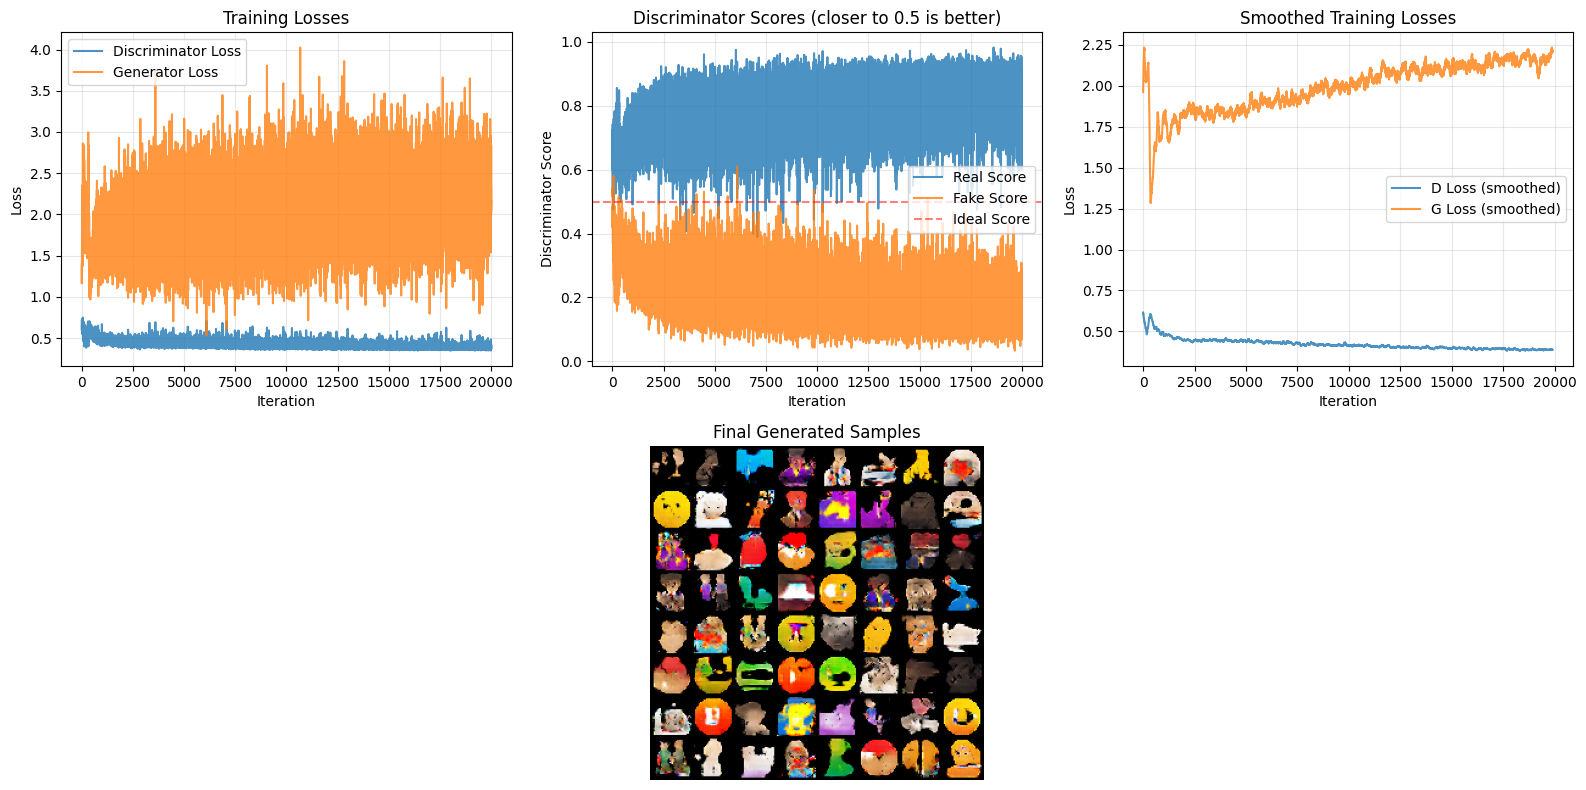


CALCULATING FID SCORE using torchmetrics


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 404MB/s]


Loading real images for FID evaluation...
Processing real images...


Processing real images:  81%|████████  | 47/58 [00:11<00:02,  4.25it/s]


Processed 3008 real images
Generating and processing fake images...
Generated 3000 fake images
Calculating FID score...

FID Score: 89.0553
Lower FID scores indicate better image quality
Typical FID ranges:
  - Excellent: < 10
  - Good: 10-30
  - Fair: 30-50
  - Poor: > 50

Saving generated samples...

FID Evaluation completed!
Final FID Score: 89.0553


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

# Install torchmetrics if not already installed
# !pip install torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance

# Improved configuration
batch_size = 64
z_dim = 100
iterations = 20000
save_interval = 200
lr_g = 0.0002  # Generator learning rate
lr_d = 0.0001  # Lower discriminator learning rate for balance
latent_size = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Improved weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Improved generator with better architecture
generator = nn.Sequential(
    nn.Linear(100, 4*4*256),  # Increased capacity
    nn.Unflatten(1, (256, 4, 4)),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
).to(device)

# Improved discriminator with dropout for regularization
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU instead of ReLU
    nn.Dropout2d(0.25),  # Add dropout

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout2d(0.25),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Dropout2d(0.25),

    nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
).to(device)

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

# Helper functions
def denorm(img_tensors):
    return (img_tensors + 1) / 2

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Dataset setup
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Update this path to your dataset
dataset = datasets.ImageFolder(root="/content/joypixels-32", transform=transform)
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, device)

# Loss & Optimizers with different learning rates
criterion = nn.BCELoss()
opt_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))  # Lower LR for discriminator
opt_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))

# Learning rate schedulers for stability
scheduler_d = optim.lr_scheduler.ExponentialLR(opt_d, gamma=0.999)
scheduler_g = optim.lr_scheduler.ExponentialLR(opt_g, gamma=0.999)

# Fixed latent for visualization
fixed_latent = torch.randn(64, latent_size, device=device)

# Improved training functions with label smoothing
def train_discriminator(real_images):
    opt_d.zero_grad()

    # Real images with label smoothing
    real_targets = torch.ones(real_images.size(0), device=device) * 0.9  # Label smoothing
    real_preds = discriminator(real_images).squeeze()
    real_loss = criterion(real_preds, real_targets)

    # Fake images
    z = torch.randn(real_images.size(0), latent_size, device=device)
    fake_images = generator(z)
    fake_targets = torch.zeros(real_images.size(0), device=device) + 0.1  # Label smoothing
    fake_preds = discriminator(fake_images.detach()).squeeze()
    fake_loss = criterion(fake_preds, fake_targets)

    # Combine losses
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    opt_d.step()

    return d_loss.item(), real_preds.mean().item(), fake_preds.mean().item()

def train_generator(batch_size):
    opt_g.zero_grad()
    z = torch.randn(batch_size, latent_size, device=device)
    fake_images = generator(z)
    fake_targets = torch.ones(batch_size, device=device)  # No smoothing for generator
    preds = discriminator(fake_images).squeeze()
    g_loss = criterion(preds, fake_targets)
    g_loss.backward()
    opt_g.step()
    return g_loss.item(), preds.mean().item()

# Create directories
sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)

# Training Loop with adaptive training
print("Starting improved training...")
d_losses, g_losses = [], []
real_scores, fake_scores = [], []
iter_count = 0

pbar = tqdm(range(iterations))
while iter_count < iterations:
    for real_images, _ in train_dl:

        # Train discriminator
        d_loss, real_score, fake_score = train_discriminator(real_images)

        # Adaptive training: train generator more if discriminator is too strong
        g_steps = 1
        if real_score > 0.8 and fake_score < 0.2:  # Discriminator too strong
            g_steps = 2
        elif real_score < 0.6 and fake_score > 0.4:  # Generator too strong
            g_steps = 1
            # Train discriminator one more time
            d_loss_extra, _, _ = train_discriminator(real_images)
            d_loss = (d_loss + d_loss_extra) / 2

        # Train generator (possibly multiple times)
        g_loss_total = 0
        for _ in range(g_steps):
            g_loss, fake_score_g = train_generator(real_images.size(0))
            g_loss_total += g_loss
        g_loss = g_loss_total / g_steps

        d_losses.append(d_loss)
        g_losses.append(g_loss)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Update learning rates occasionally
        if iter_count % 1000 == 0 and iter_count > 0:
            scheduler_d.step()
            scheduler_g.step()

        # Save samples every 200 iterations
        if iter_count % save_interval == 0:
            with torch.no_grad():
                fake_images = generator(fixed_latent).cpu()
                save_image(denorm(fake_images), os.path.join(sample_dir, f"sample-{iter_count:05d}.png"), nrow=8)
            print(f"Iter [{iter_count:05d}/{iterations:05d}]  D_loss: {d_loss:.4f}  G_loss: {g_loss:.4f}  Real_score: {real_score:.3f}  Fake_score: {fake_score:.3f}")

        iter_count += 1
        pbar.update(1)
        if iter_count >= iterations:
            break

pbar.close()
print("Training completed!")

# Save final models
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')

# Enhanced plotting
plt.figure(figsize=(16, 8))

plt.subplot(2, 3, 1)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
plt.plot(g_losses, label='Generator Loss', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
plt.plot(real_scores, label='Real Score', alpha=0.8)
plt.plot(fake_scores, label='Fake Score', alpha=0.8)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Ideal Score')
plt.xlabel('Iteration')
plt.ylabel('Discriminator Score')
plt.legend()
plt.title('Discriminator Scores (closer to 0.5 is better)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
# Moving average of losses for cleaner visualization
window = 100
if len(d_losses) > window:
    d_losses_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
    g_losses_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
    plt.plot(d_losses_smooth, label='D Loss (smoothed)', alpha=0.8)
    plt.plot(g_losses_smooth, label='G Loss (smoothed)', alpha=0.8)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Smoothed Training Losses')
    plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
# Show final generated samples
with torch.no_grad():
    final_samples = generator(fixed_latent)
    final_samples = denorm(final_samples)
    plt.imshow(make_grid(final_samples, nrow=8).permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.title('Final Generated Samples')

plt.tight_layout()
plt.show()

# =============================================================================
# FID EVALUATION using torchmetrics
# =============================================================================

from torchmetrics.image.fid import FrechetInceptionDistance

def generate_fake_images(generator, num_images, batch_size, device, latent_size):
    """Generate fake images using the trained generator"""
    generator.eval()
    fake_images = []

    with torch.no_grad():
        for i in tqdm(range(0, num_images, batch_size), desc="Generating fake images"):
            current_batch_size = min(batch_size, num_images - i)
            z = torch.randn(current_batch_size, latent_size, device=device)
            fake_batch = generator(z)
            fake_images.append(fake_batch.cpu())

    return torch.cat(fake_images, dim=0)

def convert_images_for_fid(images):
    """Convert images from [-1,1] to [0,255] uint8 format for FID calculation"""
    images = (images + 1) / 2
    images = (images * 255).clamp(0, 255).to(torch.uint8)
    return images

# FID Evaluation
print("\n" + "="*50)
print("CALCULATING FID SCORE using torchmetrics")
print("="*50)

fid_metric = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

print("Loading real images for FID evaluation...")
real_dataset = datasets.ImageFolder(root="/content/joypixels-32", transform=transform)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=64, shuffle=True)
real_dataloader = DeviceDataLoader(real_dataloader, device)

real_count = 0
max_real_images = 3000

print("Processing real images...")
for real_batch, _ in tqdm(real_dataloader, desc="Processing real images"):
    if real_count >= max_real_images:
        break

    real_images_fid = convert_images_for_fid(real_batch)
    fid_metric.update(real_images_fid, real=True)
    real_count += len(real_batch)

print(f"Processed {real_count} real images")

print("Generating and processing fake images...")
fake_count = 0
max_fake_images = 3000
fake_images_for_saving = []

while fake_count < max_fake_images:
    current_batch_size = min(batch_size, max_fake_images - fake_count)

    with torch.no_grad():
        z = torch.randn(current_batch_size, latent_size, device=device)
        fake_batch = generator(z)

    fake_images_fid = convert_images_for_fid(fake_batch)
    fid_metric.update(fake_images_fid, real=False)

    if fake_count < 64:
        fake_images_for_saving.append(fake_batch.cpu())

    fake_count += len(fake_batch)

print(f"Generated {fake_count} fake images")

print("Calculating FID score...")
fid_score = fid_metric.compute()

print(f"\nFID Score: {fid_score:.4f}")
print(f"Lower FID scores indicate better image quality")
print(f"Typical FID ranges:")
print(f"  - Excellent: < 10")
print(f"  - Good: 10-30")
print(f"  - Fair: 30-50")
print(f"  - Poor: > 50")

if fake_images_for_saving:
    print("\nSaving generated samples...")
    sample_images = torch.cat(fake_images_for_saving[:8], dim=0)
    save_image(denorm(sample_images[:64]), "fid_evaluation_samples.png", nrow=8)

print(f"\nFID Evaluation completed!")
print(f"Final FID Score: {fid_score:.4f}")

In [ ]:
!pip install torch-fidelity